# 基于Mask R-CNN的图像实例分割（Instance Segmentation）
在过去的学习中，我们已经认识到了两类图像处理问题：
- **语义分割** 将给定图像中的每一个像素分类到某个类别当中
- **目标检测** 检测图像中是否有感兴趣的目标存在并给出其bounding box
在语义分割当中，我们可以得到图形像素的分类，但是却并**不能在这个过程中检测到目标**。在目标检测中，我们可以检测到目标但是无法得到目标的具体形状。因此自然而然可以想到是否能够组合这两种方法各自的优势。这就带来了**实例分割**。下图展示了它们之间的区别：

![avatar](.asset/example.ppm)

在实例分割中，我们不仅可以得到目标的bounding box，还可以得到目标形状的mask。

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import models
from PIL import Image
import random
import cv2 as cv

COCO_INSTANCE_CATEGORY_NAMES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [2]:
maskrcnn = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()
print(maskrcnn)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\MK9/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100.0%


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
def get_pred(model, img_path, th):
    img = Image.open(img_path)
    trf = T.Compose([T.ToTensor()])
    img = trf(img)
    pred = model(img.unsqueeze(0))
    pred_score = list(pred[0]['scores'].detach().numpy())
    masks = (pred[0]['masks']>0.5).squeeze().detach().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy().astype(np.uint))]
    
    pred_t = [pred_score.index(x) for x in pred_score if x>th][-1]
    
    return masks[:pred_t+1], pred_boxes[:pred_t+1], pred_class[:pred_t+1] 

In [6]:
def random_color_masks(img):
    colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(img).astype(np.uint8)
    g = np.zeros_like(img).astype(np.uint8)
    b = np.zeros_like(img).astype(np.uint8)
    r[img == 1], g[img == 1], b[img == 1] = colors[random.randrange(0, 10)]
    colored_mask = np.stack([r, g, b], axis=2)
    return colored_mask

In [8]:
def inst_seg_api(model, img_path, th=0.5, rect_th=3, text_size=3, text_th=3):
    masks, boxes, pred_cls = get_pred(model, img_path, th)
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    for i in range(len(masks)):
        rgb_mask = random_color_masks(masks[i])
        img = cv.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv.rectangle(img, boxes[i][0], boxes[i][1], color=(0,255,0), thickness=rect_th)
        cv.putText(img, pred_cls[i], boxes[i][0], cv.FONT_HERSHEY_SIMPLEX, text_size, (0, 255,0), thickness=text_th)
    
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.axis('off')

C:\Users\MK9\.conda\envs\cv\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


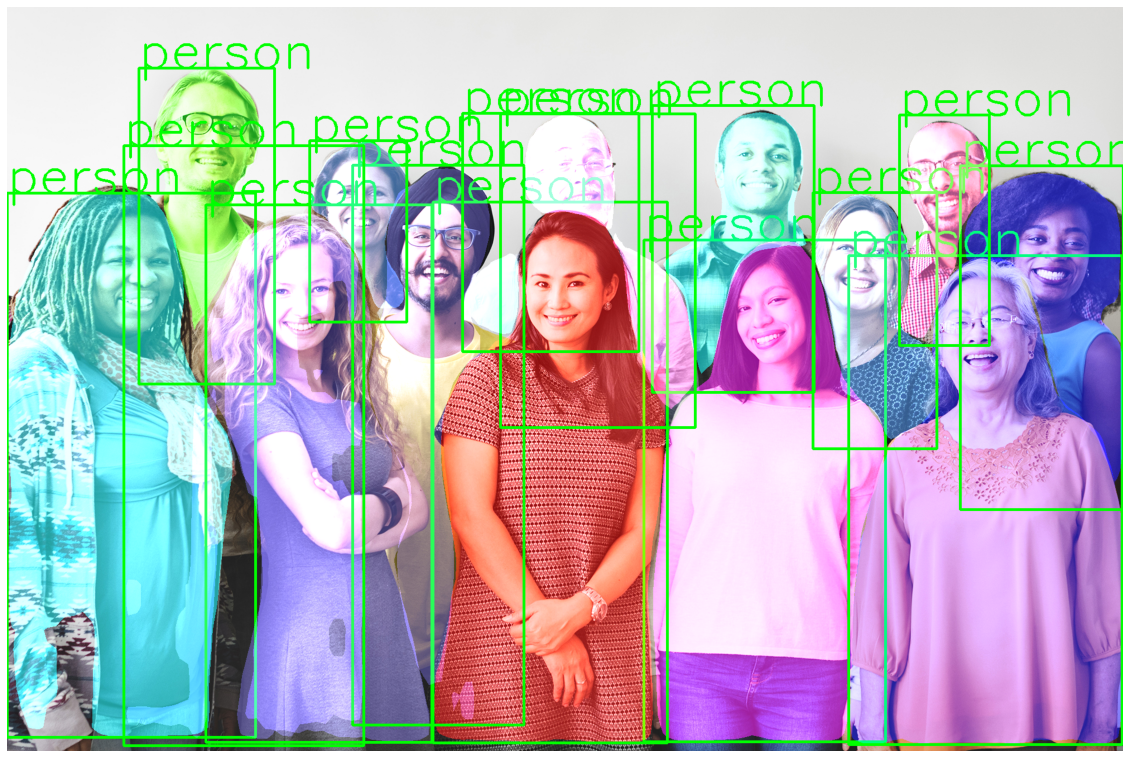

In [9]:
img_path = './raw/faster_rcnn/people.jpg'
inst_seg_api(maskrcnn, img_path)